In [1]:
%load_ext autoreload
%autoreload 2
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import gymnasium as gym
from agents import SACAgent2
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import wandb
import torch as T
from gymnasium.wrappers import RecordVideo
from EnvironmentUtils import LunarEnvHypercubeFabric, LunarEnvRandomFabric, LunarEnvFixedFabric, ValidationHypercube
from agents import SACAgent2, DDPGAgent, SACAgent, PEARLAgent
import numpy as np
from utils import *
os.environ["SDL_VIDEODRIVER"] = "dummy"
import plotly.express as px
import pandas as pd
import shutil

In [2]:
import wandb
api = wandb.Api()
# vanilla pearl best run
#run = api.run("tum-adlr-ws22-06/ADLR randomized envs/2eqd07v7")

In [3]:
#runs = [...]
# for each run:
#     download best model
#     create directory with validation/run_name
#     create hypercube with 5 points
#     for each hypercube point:
#          create subdirectory
#          make run, record video
#          store reward in result array
# make 3d plotly plots with reward as point color
# make nice gifs, comparing sac2 with and without domain parameters

In [4]:
runs = ["tum-adlr-ws22-06/ADLR Unified training/ywoxwzcp"]

In [5]:
run = api.run(runs[0])
agent = load_last_model(get_agent_from_run_cfg(run.config), run)

wandb:   6 of 6 files downloaded.  


Last model loaded from .\artifacts\lunar_lander_model-v914


In [6]:
training_args = run.config['training']
env_args = run.config['env']
validation_args = run.config['validation']

In [7]:
fabric = LunarEnvHypercubeFabric(pass_env_params=training_args['pass_env_parameters'],
                                                render_mode='rgb_array',
                                                points_per_axis=validation_args[
                                                    "hypercube_points_per_axis"], **env_args)

In [8]:
sampling_traj = 3

In [9]:

#for run_name in runs:
res = []
#run = api.run(run_name)
folder = f"final_validations/{run.name}"
if os.path.exists(folder):
    shutil.rmtree(folder, ignore_errors=True)
os.mkdir(folder)
print(run.name)
#agent = load_best_model(get_agent_from_run_cfg(run.config), run)
#fabric = LunarEnvHypercubeFabric(run.config['training']['pass_env_parameters'], run.config['env'], points_per_axis=5, render_mode='rgb_array') 
number_points = fabric.number_of_test_points()
all_actions = []
all_means = []
all_vars = []
for i in range(number_points):
    agent.clear_z()
    env = fabric.generate_env()[2]
    gravity, wind_power, turbulence_power = env.gravity, env.wind_power, env.turbulence_power
    video_path = f"{folder}/gravity_{gravity}_wind_{wind_power}_turbulence_{turbulence_power}/"
    os.mkdir(video_path)
    #env = RecordVideo(env, video_folder=video_path)
    action_list = []
    
    for traj_number in range(sampling_traj):
        if traj_number == sampling_traj - 1:
            env = RecordVideo(env, video_folder=video_path)
            with T.no_grad():
                agent.infer_posterior(agent.context)
        obs, _ = env.reset()
        rewards = 0
        while True:

            # Get deterministic action
            with T.no_grad():
                action = agent.action(obs, addNoise=False)
            if traj_number == sampling_traj - 1:
                action_list.append(action)

            # Take step in environment
            new_obs, reward, done, _, _ = env.step(action)

            # Update obs
            obs = new_obs

            # Update rewards
            rewards += reward
            agent.update_context([obs, action, reward, new_obs])

            # End episode if done
            if done:
                break
    all_actions.append(action_list)
    all_means.append(agent.z_means)
    all_vars.append(agent.z_vars)
    print(f"gravity: {gravity}, wind_power: {wind_power}, turbulence_power: {turbulence_power}, reward: {rewards}")
    res.append({"gravity": gravity, "wind_power": wind_power, "turbulence_power": turbulence_power, "reward": rewards})
df = pd.DataFrame(res)
df.to_csv(f"{folder}/results.csv", index=False)

pearl_latent_4_ood


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 5.0, turbulence_power: 0.6, reward: 291.52418302826595


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 5.0, turbulence_power: 0.8, reward: 262.4095423085628


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4



c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 5.0, turbulence_power: 1.0, reward: 277.5759635427929
Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 7.5, turbulence_power: 0.6, reward: 24.081558424622955


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 7.5, turbulence_power: 0.8, reward: 266.9867536200869


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 7.5, turbulence_power: 1.0, reward: 264.38969180275365


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10.0, turbulence_power: 0.6, reward: 37.57745680138305


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4



c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10.0, turbulence_power: 0.8, reward: 268.4550410011409
Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-11.999_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10.0, turbulence_power: 1.0, reward: 268.47264745063114


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 5.0, turbulence_power: 0.6, reward: 286.13398378940127


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 5.0, turbulence_power: 0.8, reward: 260.3684371640114


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 5.0, turbulence_power: 1.0, reward: 264.23616286351785


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 7.5, turbulence_power: 0.6, reward: 183.2056496007766


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 7.5, turbulence_power: 0.8, reward: 224.98147329825184


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 7.5, turbulence_power: 1.0, reward: 274.1838466602378


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 10.0, turbulence_power: 0.6, reward: -0.8405149754727859


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 10.0, turbulence_power: 0.8, reward: 64.45589219213849


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-9.499500000000001_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -9.499500000000001, wind_power: 10.0, turbulence_power: 1.0, reward: 267.6449174107909


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 5.0, turbulence_power: 0.6, reward: 283.31492131740436


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 5.0, turbulence_power: 0.8, reward: 279.5260883257234


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_5.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 5.0, turbulence_power: 1.0, reward: 266.24019741621555


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.6\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 7.5, turbulence_power: 0.6, reward: 271.4310244323735


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_0.8\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 7.5, turbulence_power: 0.8, reward: 264.1877399888381


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_7.5_turbulence_1.0\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 7.5, turbulence_power: 1.0, reward: 276.77138530913015


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.6 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.6\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 10.0, turbulence_power: 0.6, reward: 273.4312412833694


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_0.8\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 10.0, turbulence_power: 0.8, reward: 245.24643022460097


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_1.0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl_latent_4_ood\gravity_-7.0_wind_10.0_turbulence_1.0\rl-video-episode-0.mp4
gravity: -7.0, wind_power: 10.0, turbulence_power: 1.0, reward: 277.04859032510217


In [10]:
all_actions = [np.array(actions) for actions in all_actions]

In [11]:
#process all means from list of tensorts to np array
all_means = np.array([m.detach().numpy() for m in all_means])
all_vars = np.array([v.detach().numpy() for v in all_vars])

In [12]:
all_means = all_means.reshape(all_means.shape[0],  -1)
all_vars = all_vars.reshape(all_vars.shape[0],  -1)

In [13]:
df = pd.DataFrame(res)


In [14]:
#adding means and vars to df
df['latent mean 1'] = all_means[:,0]
df['latent mean 2'] = all_means[:,1]
df['latent mean 3'] = all_means[:,2]
df['latent mean 4'] = all_means[:,3]
df['var_0'] = all_vars[:,0]
df['var_1'] = all_vars[:,1]
df['var_2'] = all_vars[:,2]
df['var_3'] = all_vars[:,3]


In [15]:
df['sum_of_vars'] = df['var_0'] + df['var_1'] + df['var_2'] + df['var_3']
df['max_of_vars'] = df[['var_0', 'var_1', 'var_2', 'var_3']].max(axis=1)

In [16]:
# SHOW HOW PEARL WORKS FOR THE BEST SAC2 CASE, HOW TO WORST
# and, the opposite

Text(0.5, 1.0, 'PEARL, Correlation map between environment parameters and latent space means in OOD setting')

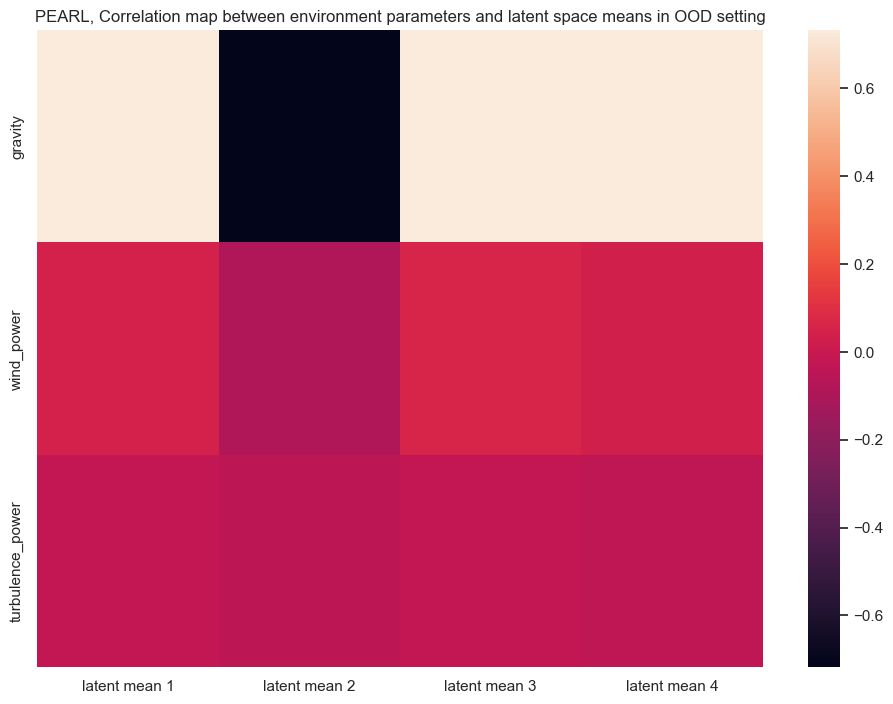

In [17]:
#calculating correlation map between env params and means of latent space
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
heatmap = df[['gravity', 'wind_power', 'turbulence_power', 'latent mean 1', 'latent mean 2', 'latent mean 3', 'latent mean 4']].corr()
heatmap = heatmap.iloc[[0,1,2], [3, 4,5,6]]
#displaying correlation map
fig = sns.heatmap(heatmap)
fig.set_title("PEARL, Correlation map between environment parameters and latent space means in OOD setting")

In [36]:
task_id = 8

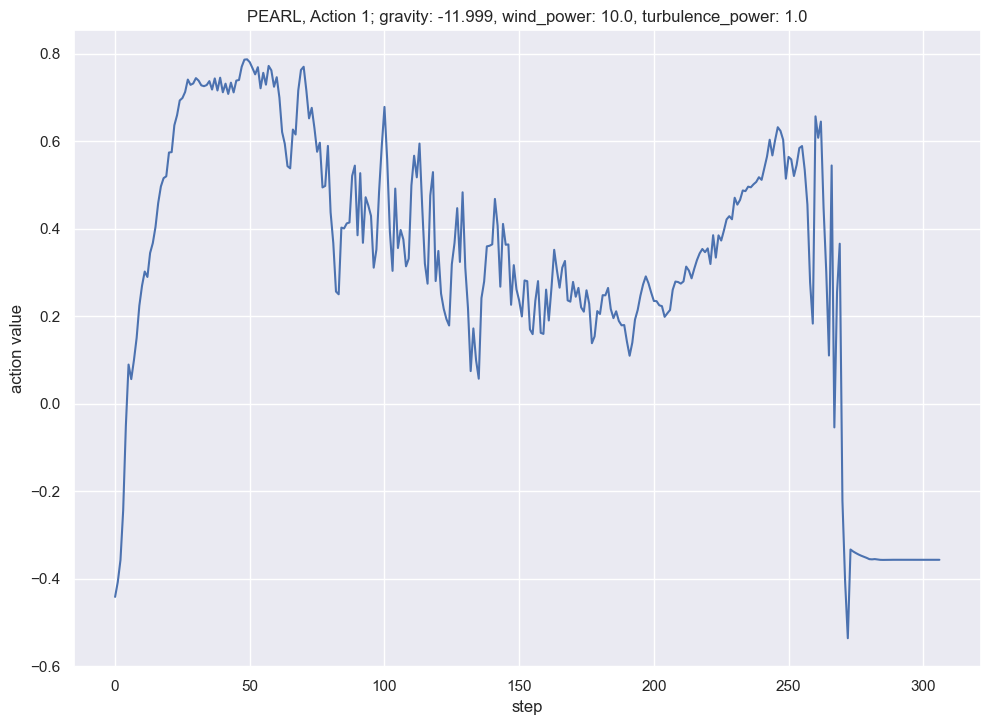

In [37]:
#lineplot of first actions
plt.plot(all_actions[task_id][:, 0]);
#title with env params from df
plt.title(f"PEARL, Action 1; gravity: {df['gravity'][task_id]}, wind_power: {df['wind_power'][task_id]}, turbulence_power: {df['turbulence_power'][task_id]}");
plt.xlabel('step');
plt.ylabel('action value');
#plt.title("PEARL, Action 1");

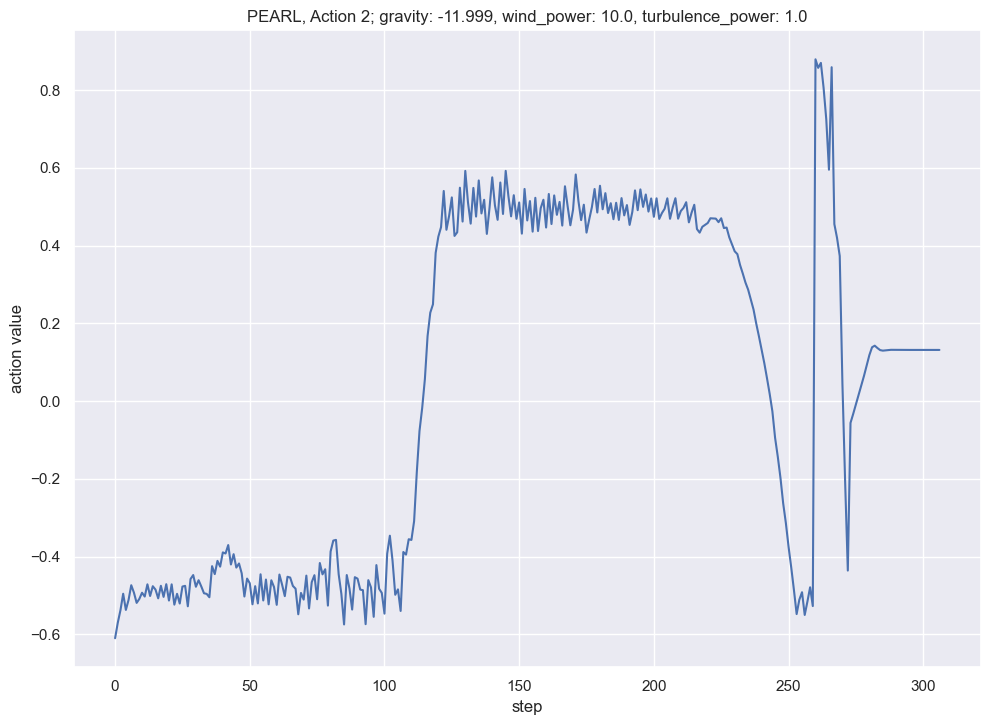

In [38]:
#lineplot of first actions
plt.plot(all_actions[task_id][:, 1]);
plt.title(f"PEARL, Action 2; gravity: {df['gravity'][task_id]}, wind_power: {df['wind_power'][task_id]}, turbulence_power: {df['turbulence_power'][task_id]}");
plt.xlabel('step');
plt.ylabel('action value');

<AxesSubplot: xlabel='max_of_vars', ylabel='reward'>

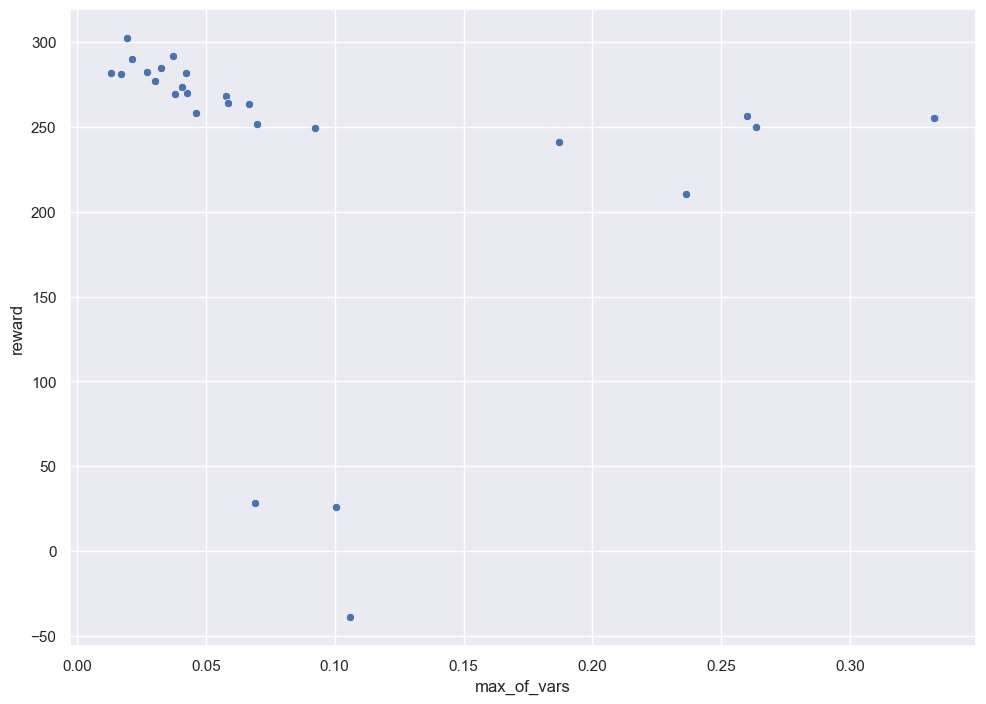

In [61]:
#scatterplot of sum of latent vars vs reward
sns.scatterplot(data=df, x="max_of_vars", y="reward")

In [21]:
fig = px.scatter_3d(df, x='gravity', y='wind_power', z='turbulence_power',
              color='reward')
fig.show()

In [29]:
df

,gravity,wind_power,turbulence_power,reward,latent mean 1,latent mean 2,latent mean 3,latent mean 4,var_0,var_1,var_2,var_3,sum_of_vars,max_of_vars
0,-11.9990,5.0,0.6,291.524183,-0.524507,0.212907,-2.108798,-0.474705,0.001708,0.002211,0.000901,0.001951,0.006771,0.002211
1,-11.9990,5.0,0.8,262.409542,-0.586042,0.204715,-2.277114,-0.543602,0.087840,0.112857,0.044243,0.100371,0.345311,0.112857
2,-11.9990,5.0,1.0,277.575964,-0.615832,0.211906,-2.398802,-0.566640,0.117704,0.150827,0.058099,0.134749,0.461379,0.150827
3,-11.9990,7.5,0.6,24.081558,-0.832723,0.235128,-3.006399,-0.776366,0.261911,0.336455,0.129713,0.300453,1.028531,0.336455
4,-11.9990,7.5,0.8,266.986754,-0.521206,0.196040,-2.092316,-0.495520,0.060162,0.077595,0.031147,0.068661,0.237565,0.077595
5,-11.9990,7.5,1.0,264.389692,-0.661615,0.231326,-2.504723,-0.559708,0.032407,0.041978,0.017332,0.037082,0.128798,0.041978
6,-11.9990,10.0,0.6,37.577457,-0.534394,0.199654,-2.103364,-0.484570,0.090624,0.115792,0.043724,0.103693,0.353834,0.115792
7,-11.9990,10.0,0.8,268.455041,-0.697512,0.218248,-2.626576,-0.639868,0.165192,0.212714,0.084594,0.189119,0.651619,0.212714
8,-11.9990,10.0,1.0,268.472647,-0.662363,0.201878,-2.389832,-0.619937,0.248357,0.318794,0.121787,0.284732,0.973670,0.318794
9,-9.4995,5.0,0.6,286.133984,-0.255376,0.129679,-1.149624,-0.284833,0.030158,0.038329,0.013882,0.034341,0.116709,0.038329


In [7]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    

In [10]:
env_fabric = LunarEnvHypercubeFabric(env_params=cfg.env, pass_env_params=True)
env = env_fabric.generate_env()
env_info = {"input_dims":env.observation_space.shape, "n_actions": env.action_space.shape[0], "max_action": env.action_space.high}

c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [19]:
@widgets.interact_manual(g=(-12.0, 0.0), wind_power=(0.0, 20.0), turbulence_power=(0.0, 2.0)
                         )
def make_video(g=-10, wind_power=0.0, turbulence_power=0.0, plot_every_action=5):
    env = gym.make('LunarLander-v2', continuous=True, render_mode='rgb_array', gravity=g , enable_wind=True, wind_power=wind_power, 
             turbulence_power=turbulence_power)
    obs, info = env.reset()
    step = 0
    while True:
        action = agent.action(obs, addNoise=False)
        new_obs, reward, done, _, _ = env.step(action)
        if step % plot_every_action == 0:
            clear_output(wait=True)
            plt.imshow( env.render())
            plt.show()
        step += 1
        if done:
            break
    env.close()

interactive(children=(FloatSlider(value=-10.0, description='g', max=0.0, min=-12.0), FloatSlider(value=0.0, de…